In [1]:
import numpy as np
from scipy.linalg import sqrtm
import scipy as sc
import matplotlib.pyplot as plt
import scipy
import random
import numba as numba
from numpy import complex128
from numba.typed import Dict
from numba import types
from scipy.optimize import curve_fit

import time
n_qubits=6
accuracy=0.99
c=0.5

# Definition of the quantum gates

In [2]:
X=np.array([[0,1],[1,0]],dtype=complex128)
Y=np.array([[0,-1j],[1j,0]],dtype=complex128)
Z=np.array([[1,0],[0,-1]],dtype=complex128)
sigma=np.array([np.eye(2,dtype=complex128),X,Y,Z])
sigma_symbols=np.array(["I","X","Y","Z"],dtype=np.str_)
I=np.eye(2,dtype=complex128)
H=np.array([[1,1],[1,-1]],dtype=complex128)/np.sqrt(2)
CNOT_ideal=np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]],dtype=complex128)

# Numpy transformations

In [3]:
@numba.njit(parallel=True)
def get_psi(n_qubits): #Random state Haar measure
    psi=np.zeros((2**n_qubits,1),dtype=complex128)
    for i in numba.prange(2**n_qubits):
        psi[i][0]=complex(np.random.normal())
        psi[i][0]+=1j*np.random.normal()
    psi=psi/(np.sqrt((psi.conjugate().T@psi)[0][0]))
    psi=psi/np.exp(1j*np.angle(psi[0][0]))
    return psi

@numba.njit
def equal(a,b):
    return np.linalg.norm(a-b)<0.000001 #проверка равентства матриц

@numba.njit
def is_unitary(matrix):
    cond=np.linalg.norm(np.eye(int(np.sqrt(matrix.size)))-matrix.dot(matrix.transpose().conjugate()))
    if cond<1e-3:
        return True
    else:
        return False

@numba.njit
def is_hermit(matrix): #return True if matrix is hermitian
    return np.linalg.norm(matrix.T.conjugate()-matrix)<0.0000001

@numba.njit
def trace(a):
    return np.trace(a)/len(a)

@numba.njit
def h_decompose(matrix): #decompose a matrix to sum of the 2 hermitian operators
    H1=0.5*(matrix+matrix.T.conjugate())
    H2=-0.5j*(matrix-matrix.T.conjugate())
    return H1,H2

def u_decompose(A): #decompose a hermitian matrix to sum of 2 unitaries
    U1=A+1j*sqrtm(np.eye(len(A))-A@A)
    U2=A-1j*sqrtm(np.eye(len(A))-A@A)
    return U1,U2

@numba.njit
def Rx(theta):
    return np.array([[np.cos(theta/2),-1j*np.sin(theta/2)],[-1j*np.sin(theta/2),np.cos(theta/2)]])

@numba.njit
def Ry(theta):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)],[np.sin(theta/2),np.cos(theta/2)]])

@numba.njit
def QFT(n=n_qubits): # return a matrix correspond to the n_qubits Quantum Fourier transform
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype=complex128)
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)

@numba.njit
def L(n=n_qubits): # return a n_qubits permutation matrix
    matrix=np.zeros((2**n,2**n),dtype=complex128)
    for i in range(2**n):
        matrix[i][i-1]=1
    return matrix

@numba.njit
def U3gate(x,y,z):
    return np.array([[np.cos(x/2),(-1)*np.exp(1j*z)*np.sin(x/2)],[np.exp(1j*y)*np.sin(x/2),np.exp(1j*(y+z))*np.cos(x/2)]],dtype=complex128)

@numba.njit
def CU3gate(x,y,z):
    matrix=np.kron(np.eye(2,dtype=complex128),U3gate(x,y,z))
    matrix[0,0]=1
    matrix[0,1]=0
    matrix[1,0]=0
    matrix[1,1]=1
    return matrix

@numba.njit
def two_qubit_state(state):
    if np.imag(state[0][0])>0.00000001:
        print("invalid state")
    x1=2*np.arccos(np.sqrt(np.abs(state[0][0])**2+np.abs(state[1][0])**2))
    x2=np.angle(state[2][0])
    y1=2*np.arctan(np.abs((state[1][0]))/(np.abs(state[0][0])))
    y2=np.angle(state[1][0])
    z1=2*np.arccos(np.abs(state[2][0])/np.sqrt(1-np.abs(state[0][0])**2-np.abs(state[1][0])**2))-y1
    z2=np.angle(state[3][0])-np.angle(state[2][0])
    return CU3gate(z1,z2,-y2)@np.kron(U3gate(x1,x2,0),U3gate(y1,y2,0))

@numba.njit
def QFT(n=n_qubits):
    w=np.exp(2j*np.pi/(2**n))
    gate=np.zeros((2**n,2**n),dtype=complex128)
    for i in range(2**n):
        for j in range(2**n):
            gate[i][j]=w**(i*j)
    return gate/np.sqrt(2**n)

def rho_fidelity(a,b):
    fidelity=(np.trace(sqrtm(sqrtm(a)@b@sqrtm(a))))**2
    if np.abs(np.imag(fidelity))>0.0000001:
        print("error")
        return 0
    return np.real(fidelity) 

# Pauli string decomposition

In [4]:
# @numba.njit
def convert_base(value, base, length=16,n_qubits=n_qubits):# меняет систему исчесления (10-ричную в другую)
    res = ''
    while value > 0:
        res = str(value % base) + res
        value //= base
    while len(res)<n_qubits:
        res="0"+res
    return res

# разложение на строчки Паули 
# return an array of coefficients for all possible Pauli strings
def decompose(A,n_qubits=n_qubits):     
    parameters=np.array([])
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        parameters=np.append(parameters,trace(A@a))
    return parameters

def compose(parameters,n_qubits=n_qubits): # сборка по параметрам разложения compose(decompose(A))=A
    A=np.zeros((2**n_qubits,2**n_qubits),dtype="complex")
    for i in range(4**n_qubits):
        a=sigma[int(convert_base(i,4,n_qubits=n_qubits)[0])]
        for j in range(1,n_qubits):
            a=np.kron(a,sigma[int(convert_base(i,4,n_qubits=n_qubits)[j])])
        A=A+parameters[i]*a
    return A

# Auxiliary function for Pauli strings decomposition
# This function is needed beacause we use the @convert_base
def Pauli_system(a): 
    Pauli_string=''
    for i in range(len(a)):
        if a[i]=='0':
            Pauli_string+="I"
        if a[i]=="1":
            Pauli_string+="X"
        if a[i]=="2":
            Pauli_string+="Y"
        if a[i]=="3":
            Pauli_string+="Z"
    return Pauli_string 

def char_split(s): #return array of symbols of string (change format to integer)
    return np.int32(np.array([char for char in s]))

#write decomposition to Pauli strings and return non-zero strings (array of arrays with number of Pauli matrices)
def write_decomposition(parameters,n_qubits=n_qubits):
    a=""
    b=np.array([],dtype=np.int32)
    for i in range(len(parameters)):
        if np.abs(parameters[i])>0.00001:
            if np.imag(parameters[i])==0:
                if np.real(parameters[i])>0:
                    print("+ "+str(np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.real(parameters[i]))+" "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            elif np.real(parameters[i])==0:
                if np.imag(parameters[i])>0:
                    print("+ "+str(np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- "+str(-np.imag(parameters[i]))+"i "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ") 
            else:
                if np.imag(parameters[i])>0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"+ "+str(np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])<0 and np.real(parameters[i])>0:
                    print("+ ("+str(np.real(parameters[i]))+"- "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                elif np.imag(parameters[i])>0 and np.real(parameters[i])<0:
                    print("+ (-"+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
                else:
                    print("- ("+str(np.real(parameters[i]))+"+ "+str(-np.imag(parameters[i]))+"i) "+Pauli_system(convert_base(i,4,n_qubits=n_qubits)),end=" ")
            b=np.append(b,char_split(convert_base(i,4,n_qubits=n_qubits)))
    return b.reshape((int(len(b)/n_qubits),n_qubits))

# return matrices in decomposition (first use decompose function) 
#  Unitaries(decompose(A))
def Unitaries(decomposition,n_qubits=n_qubits): 
    Unit=np.eye(2**n_qubits,dtype="complex")
    for i in range(1,len(decomposition)):
        if np.abs(decomposition[i])>0.001:
            a=sigma[int(convert_base(i,4)[0])]
            for j in range(1,n_qubits):
                a=np.kron(a,sigma[int(convert_base(i,4)[j])])
            Unit=np.append(Unit,a,axis=0)
    return np.reshape(Unit,(len(decomposition[decomposition!=0]),2**n_qubits,2**n_qubits))

# A matrix

In [5]:
#creation A
@numba.njit
def create_A(c,n_qubits=n_qubits):
    A=np.zeros((2**n_qubits,2**n_qubits),dtype=complex128)
    for i in range(2**n_qubits):
        if i!=(2**n_qubits-1):
            A[i][i+1]=1
        if i!=0:
            A[i][i-1]=1
        A[i][i]=-2-c
    A[0][-1]=1
    A[-1][0]=1
    return A   
A=create_A(c)

#Substituion of the spectrum
# new means substituted spectrum
# F means Fourier basis
# shift means cyclic permutation 2^(n-1) times
A_new_F_shift=np.diag(np.array([-c-4*(np.pi*i/2**n_qubits-np.pi/2)**2 for i in range(2**n_qubits)])) 
A_new_F=A_new_F_shift
for i in range(2**(n_qubits-1)):
    A_new_F=L()@A_new_F@(L().T.conjugate())

#Fourier basis
A_new=QFT().T.conjugate()@A_new_F@QFT()
A_F=QFT()@A@(QFT().T.conjugate())
    
# decomposition to Pauli strings (will be printed below)
# creation of U_1, U_2, U_3, ...
set_u=write_decomposition(decompose(A_new_F)) 

#inversed matrix or pseude inversed matrix (if c=0)
if c==0:
    val,vec=np.linalg.eigh(A)
    val=np.array([1/val[i] for i in range(len(val)-1)])
    val=np.append(val,0.)
    A_1=vec@np.diag(val)@vec.T
    
    #approximation matrix
    val=np.linalg.eigh(A_new)[0]
    val=np.array([1/val[i] for i in range(len(val)-1)])
    val=np.append(val,0.)
    A_new_1=vec@np.diag(val)@vec.T
else:
    A_1=np.linalg.inv(A)
    #approximation matrix
    A_new_1=np.linalg.inv(A_new)


- 3.791474514621108 IIIIII - 0.004819142773969356 IIIIIZ - 0.00963828554793867 IIIIZI - 0.009638285547939017 IIIIZZ - 0.019276571095877555 IIIZII - 0.019276571095877867 IIIZIZ - 0.038553142191755305 IIIZZI - 0.03855314219175534 IIZIII - 0.03855314219175542 IIZIIZ - 0.0771062843835107 IIZIZI - 0.15421256876702116 IIZZII - 0.07710628438351061 IZIIII - 0.07710628438351058 IZIIIZ - 0.15421256876702133 IZIIZI - 0.30842513753404244 IZIZII - 0.6168502750680845 IZZIII + 0.15421256876702133 ZIIIII + 0.15421256876702133 ZIIIIZ + 0.30842513753404244 ZIIIZI + 0.6168502750680848 ZIIZII + 1.2337005501361693 ZIZIII + 2.46740110027234 ZZIIII 

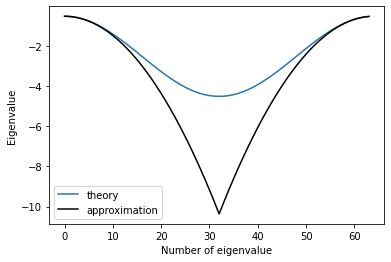

In [6]:
plt.plot(np.diag(np.real(A_F)))
plt.plot(np.real(np.diag(A_new_F)),color="black")
plt.legend(["theory","approximation"])
plt.xlabel("Number of eigenvalue")
plt.ylabel("Eigenvalue")
plt.show()

# vector b (initial state)

In [7]:
b_init=np.array([],dtype=complex)
for i in np.diag(A_new_F):
    if i!=0:
        b_init=np.append(b_init,np.random.normal()+1j*np.random.normal())
    else: #c=0 (The first value)
        b_init=np.append(b_init,0)
b_init=np.reshape(b_init,(2**n_qubits,1))
b_init/=(np.sqrt(b_init.conjugate().T@b_init))
b=QFT().T.conjugate()@b_init

# Solution for A and A_new(substituded spectrum)

In [8]:
x_true=A_1@b #True solution
x_new=A_new_1@b #Substituted spectrum true solution
x_new=x_new/np.sqrt(np.abs(x_new.T.conjugate()@x_new))
x_true=x_true/np.sqrt(np.abs(x_true.T.conjugate()@x_true))
print("100% error level = "+str((np.abs(b.T.conjugate()@x_new)**2)[0][0]))
print("Fidelity of solutions = "+str((np.abs(x_true.T.conjugate()@x_new)**2)[0][0]))

100% error level = 0.526484094430802
Fidelity of solutions = 0.9949042216392595


In [9]:
qft=QFT()
qft_cc=QFT().T.conjugate()
# return gate in real space
# string is an array of int32 digits with length = n_qubits
# @numba.njit
def gate_string(string,n_qubits=n_qubits):
    if string[0]==0:
        gate=I
    else:
        gate=Z
    for i in range(1,n_qubits):
        if string[i]==0:
            gate=np.kron(gate,I)
        else:
            gate=np.kron(gate,Z)
    return qft_cc@gate@qft

# @numba.njit
def gate_string_F(string,n_qubits=n_qubits):#return gate in Fourier space
    if string[0]==0:
        gate=I
    else:
        gate=Z
    for i in range(1,n_qubits):
        if string[i]==0:
            gate=np.kron(gate,I)
        else:
            gate=np.kron(gate,Z)
    return gate

# transform parameters 
# branch is the an array of Paulis strings (array of digits)
# x is an array of coefficients for each Pauli string in branch
# @numba.njit(parallel=True)
def x_s(branch,x,n_qubits=n_qubits,b=b):
    result=np.zeros((2**n_qubits,2**n_qubits),dtype=complex128)
    for i in range(len(x)):
        result+=x[i]*gate_string_F(branch[i],n_qubits=n_qubits)
    return qft_cc@result@qft@b


# @numba.njit
def string_multiplication(a,b,n_qubits=n_qubits):# multiplication of Pauli strings only Z and I
    result=np.zeros(n_qubits,dtype=np.int32)
    for i in range(n_qubits):
        if a[i]!=b[i]:
            result[i]=3
    return result


# @numba.njit
def presence_check(a,b):#check of presence one of array in another one
    for array in b:
        for i in range(len(a)):
            if a[i]!=array[i]:
                break
            if i==len(a)-1:
                return True
    return False

# branch,x are optimized
# This function choose a new node to append to the Ansatz tree
# @numba.njit
def tree_selection(branch,x_optimized,b=b,set_u=set_u,n_qubits=n_qubits):
    gradient_largest=0.0
    for i in range(len(set_u)):
        #pretender (str) as new nodes
        applicant=string_multiplication(branch[-1],set_u[i],n_qubits=n_qubits)
        if not presence_check(applicant,branch):
            #gradien computing for applecant
            gradient=np.abs(2*(gate_string(applicant,n_qubits=n_qubits)@b).T.conjugate()@A_new@A_new@x_s(branch,x_optimized,n_qubits=n_qubits,b=b)-2*(gate_string(applicant,n_qubits=n_qubits)@b).T.conjugate()@A@b)[0,0]

            #comparison of gradients
            if gradient>gradient_largest:
                #The selection of a new applicant
                result=applicant
                gradient_largest=gradient
            
    #return an applicant (array of digits) with max gradient overplap
    return result


# @numba.njit
def Loss_function(x,branch,n_qubits=n_qubits,b=b):#return a value of the Loss function for branch with coefficient x 
    
    #computing x_s
    state=x_s(branch,x,n_qubits=n_qubits,b=b)
    
    #Loss function value
    return np.real((state.T.conjugate()@A_new@A_new@state)-2*np.real(b.T.conjugate()@A_new@state)+1)[0][0]
    
# @numba.njit
def optimizator(branch,initial_guess,b=b,n_qubits=n_qubits,start_position=False):

    if start_position:# if True use previous branch optimal as start point
        start_point=np.array([initial_guess[i] for i in range(len(branch)-1)]+[0])

    else:
        start_point=np.array([0 for i in range(len(branch))],dtype=np.int32)
    
    #minimization of Loss_function

    x=sc.optimize.minimize((lambda y: Loss_function(y,branch=branch,n_qubits=n_qubits,b=b)),start_point)

    #forming a new branch_optimal
    x_optimized_coef=x.x
    
    #computing and normalization of the solution
    solution=x_s(branch,x_optimized_coef,n_qubits=n_qubits,b=b)
    solution/=np.sqrt(solution.T.conjugate()@solution)
    
    #computing Fidelity of accurate solution (x_new) and current "solution"
    Fidelity=(np.abs(x_new.T.conjugate()@solution)**2)[0][0]
    
    return branch,x_optimized_coef, Fidelity, x.fun       

# Algorithm

In [10]:
#Algorithm
# @numba.njit(parallel =True)
def Ansatz_tree_approach(b):    
    depth=(2**n_qubits)-1 #maximum depth of the ansatz tree
    branch=np.array([[0 for i in range(n_qubits)]]) #current branch of the ansatz tree

    #future results
    Fidelity_samples=np.array([]) 
    losses_samples=np.array([])
    i=1
    while True:
        start_time = time.time()#timer for 1 node selection (1 cycle of for)

        if i==1: #if i!=0 previous branch_opimal is used as initial guess for opitimization
            #branch opimal is the dictionary {"Pauli string": coefficient} in the x
            
            branch,x_optimized, Fidelity, losses=optimizator(branch,b=b,n_qubits=n_qubits,initial_guess=0)
        else:
            branch,x_optimized, Fidelity, losses=optimizator(branch,b=b,n_qubits=n_qubits,initial_guess=x_optimized,start_position=True)
            

        #adding to branch a new node with maximum gradient overlap    
        branch=np.append(branch,[tree_selection(branch,x_optimized,b=b,set_u=set_u,n_qubits=n_qubits)],axis=0)

        #accomodating results for plots
        Fidelity_samples=np.append(Fidelity_samples,Fidelity)
        losses_samples=np.append(losses_samples,losses)

        #monitoring results
        if (3600>(time.time() - start_time)) and ((time.time() - start_time)>60):
            print("tree depth = ",i,"Fidelity = ",Fidelity,"Lf = ",losses,"time = ",int((time.time() - start_time)/60),"minutes")
        elif time.time() - start_time<60:
            print("tree depth = ",i,"Fidelity = ",Fidelity,"Lf = ",losses,"time = ",np.round(time.time() - start_time,2),"seconds")
        else:
            print("tree depth = ",i,"Fidelity = ",Fidelity,"Lf = ",losses,"time = ",int((time.time() - start_time)/3600),"hours")
        i+=1
        if Fidelity>accuracy:
            return Fidelity_samples,losses_samples,i    

# Mean_result

In [11]:
%%time
Fidelity_samples,losses_samples,junk=Ansatz_tree_approach(b)

tree depth =  1 Fidelity =  0.5264840944308018 Lf =  0.3964231977320518 time =  0.03 seconds
tree depth =  2 Fidelity =  0.7537162160100573 Lf =  0.16944016060489286 time =  0.05 seconds
tree depth =  3 Fidelity =  0.8084424317712176 Lf =  0.11696347013385866 time =  0.07 seconds
tree depth =  4 Fidelity =  0.8227887095651001 Lf =  0.10174292561823539 time =  0.16 seconds
tree depth =  5 Fidelity =  0.8274964673936694 Lf =  0.1000253299780931 time =  0.2 seconds
tree depth =  6 Fidelity =  0.8276031210934726 Lf =  0.09996726248846577 time =  0.27 seconds
tree depth =  7 Fidelity =  0.8277213428867988 Lf =  0.09961099415227603 time =  0.49 seconds
tree depth =  8 Fidelity =  0.8281005573531228 Lf =  0.09933449253677362 time =  0.54 seconds
tree depth =  9 Fidelity =  0.8326836421497957 Lf =  0.09915744390391001 time =  0.73 seconds
tree depth =  10 Fidelity =  0.8553823244036254 Lf =  0.09548111593492081 time =  0.86 seconds
tree depth =  11 Fidelity =  0.8552807895755311 Lf =  0.095447

# Graphix

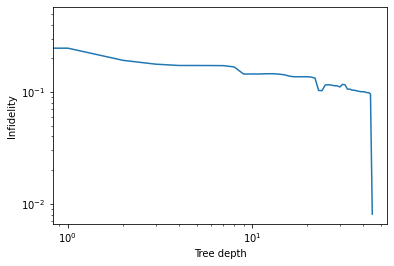

In [12]:
plt.plot(1-Fidelity_samples)
plt.xlabel("Tree depth")
plt.ylabel("Infidelity")
plt.yscale('log')
plt.xscale('log')
plt.show()

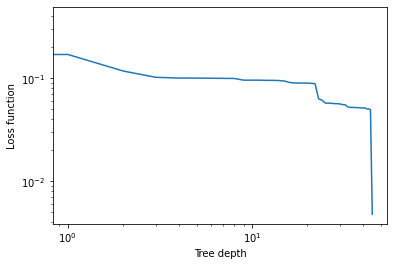

In [13]:
plt.plot(losses_samples)
plt.xlabel("Tree depth")
plt.ylabel("Loss function")
plt.yscale('log')
plt.xscale('log')
plt.show()

# DEBUG